In [20]:
unique_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000075', '#808080', '#ffffff', '#000000'
]
model_list = [
    "ACCESS-ESM1-5", "CanESM5", "CESM2", "CNRM-CM6-1", "EC-Earth3",
    "GISS-E2-1-G", "GISS-E2-1-H", "INM-CM5-0", "IPSL-CM6A-LR",
    "MIROC-ES2L", "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR",
    "MRI-ESM2-0", "NorCPM1", "UKESM1-0-LL"
]
model_colors = {model: unique_colors[i % len(unique_colors)] for i, model in enumerate(model_list)}


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from scipy import signal

conc_folder = "siarea_data/"
sea_ice_folder = "sispeed_data/"
wind_folder = "wind_speed_data/"

conc_files = sorted(glob.glob(os.path.join(conc_folder, "cmip6.historical.*.siarea.csv")))
sea_ice_files = sorted(glob.glob(os.path.join(sea_ice_folder, "*_sispeed.area_mean.csv")))
wind_files = sorted(glob.glob(os.path.join(wind_folder, "*_wind_speed.csv")))

conc_models = {os.path.basename(f).replace("cmip6.historical.", "").replace(".siarea.csv", ""): f 
               for f in conc_files}
sea_ice_models = {os.path.basename(f).replace("_sispeed.area_mean.csv", ""): f 
                  for f in sea_ice_files}
wind_models = {os.path.basename(f).replace("_wind_speed.csv", ""): f 
               for f in wind_files}

common_models = set(conc_models.keys()) & set(sea_ice_models.keys()) & set(wind_models.keys())
print("Common Models:", common_models)

Common Models: {'CanESM5', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MIROC6', 'CNRM-CM6-1', 'CESM2', 'EC-Earth3', 'ACCESS-ESM1-5', 'MPI-ESM1-2-LR'}


In [22]:
results = []  
for model in common_models:

    try:
        conc_df = pd.read_csv(conc_models[model], index_col="time", parse_dates=True)
    except ValueError:
        conc_df = pd.read_csv(conc_models[model], index_col=0, parse_dates=True)
    try:
        ice_df = pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
    except ValueError:
        ice_df = pd.read_csv(sea_ice_models[model], index_col=0, parse_dates=True)
    try:
        wind_df = pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
    except ValueError:
        wind_df = pd.read_csv(wind_models[model], index_col=0, parse_dates=True)
    
    common_time = conc_df.index.intersection(ice_df.index)
    common_time = common_time.intersection(wind_df.index)
    if common_time.empty:
        print(f"No common dates for {model}")
        continue
    conc_df = conc_df.loc[common_time]
    ice_df = ice_df.loc[common_time]
    wind_df = wind_df.loc[common_time]

    conc_march = conc_df[conc_df.index.month == 3]
    ice_march = ice_df[ice_df.index.month == 3]
    wind_march = wind_df[wind_df.index.month == 3]
    if conc_march.empty or ice_march.empty or wind_march.empty:
        print(f"March data missing for model {model}")
        continue
    
    ensemble_members = conc_march.columns.intersection(ice_march.columns).intersection(wind_march.columns)
    if ensemble_members.empty:
        ensemble_members = conc_march.columns
        
    for ens in ensemble_members:
        conc_ens = conc_march[ens]
        ice_ens = ice_march[ens]
        wind_ens = wind_march[ens]
        
        mean_conc = (conc_ens.mean())      # m²
        mean_ice_vel = ice_ens.mean()       # m/s.
        mean_wind = wind_ens.mean()           # m/s.
        
        if mean_wind == 0:
            ratio_vel_wind = np.nan
        else:
            ratio_vel_wind = mean_ice_vel / mean_wind
        if mean_conc == 0:
            ratio_vel_area = np.nan
        else:
            ratio_vel_area = mean_ice_vel / mean_conc
        
        results.append({
            "Model": model,
            "Ensemble": ens,
            "Mean Sea Ice Area (km², March)": mean_conc,
            "Mean Sea Ice Velocity (m/s, March)": mean_ice_vel,
            "Mean Wind Speed (m/s, March)": mean_wind,
            "Velocity/Wind": ratio_vel_wind,
            "Velocity/Area": ratio_vel_area
        })

results_df = pd.DataFrame(results)
print("Derived Metrics for March (by Ensemble):")
print(results_df)

Derived Metrics for March (by Ensemble):
            Model   Ensemble  Mean Sea Ice Area (km², March)  \
0         CanESM5  r25i1p1f1                    1.557640e+13   
1         CanESM5  r21i1p1f1                    1.591262e+13   
2         CanESM5   r7i1p1f1                    1.535491e+13   
3         CanESM5   r4i1p2f1                    1.609745e+13   
4         CanESM5  r25i1p2f1                    1.612764e+13   
..            ...        ...                             ...   
95  MPI-ESM1-2-LR   r4i1p1f1                    1.474734e+13   
96  MPI-ESM1-2-LR   r1i1p1f1                    1.434378e+13   
97  MPI-ESM1-2-LR   r2i1p1f1                    1.466754e+13   
98  MPI-ESM1-2-LR   r9i1p1f1                    1.443601e+13   
99  MPI-ESM1-2-LR   r3i1p1f1                    1.450470e+13   

    Mean Sea Ice Velocity (m/s, March)  Mean Wind Speed (m/s, March)  \
0                             0.140412                      5.422866   
1                             0.144898        

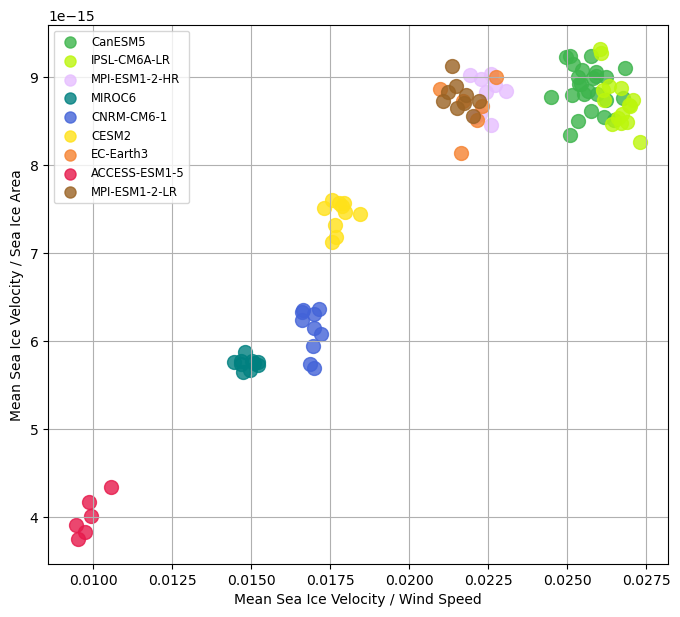

In [23]:
plt.figure(figsize=(8, 7))
plotted_models = set()
for idx, row in results_df.iterrows():
    model = row["Model"]
    x = row["Velocity/Wind"]
    y = row["Velocity/Area"]
    color = model_colors.get(model, "#000000")

    if model not in plotted_models:
        plt.scatter(x, y, color=color, s=100, alpha=0.8, label=model)
        plotted_models.add(model)
    else:
        plt.scatter(x, y, color=color, s=100, alpha=0.8)

plt.xlabel("Mean Sea Ice Velocity / Wind Speed")
plt.ylabel("Mean Sea Ice Velocity / Sea Ice Area")
# plt.title("Comparison of Sea Ice Drift Sensitivity (March) by Ensemble Member")
plt.grid(True)
plt.legend(loc="best", fontsize="small", markerscale=0.8)
plt.savefig("final_drift_sensitivity_scatter_ensembles.png", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
results = []  
for model in common_models:

    try:
        conc_df = pd.read_csv(conc_models[model], index_col="time", parse_dates=True)
    except ValueError:
        conc_df = pd.read_csv(conc_models[model], index_col=0, parse_dates=True)
    try:
        ice_df = pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
    except ValueError:
        ice_df = pd.read_csv(sea_ice_models[model], index_col=0, parse_dates=True)
    try:
        wind_df = pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
    except ValueError:
        wind_df = pd.read_csv(wind_models[model], index_col=0, parse_dates=True)
    
    common_time = conc_df.index.intersection(ice_df.index)
    common_time = common_time.intersection(wind_df.index)
    if common_time.empty:
        print(f"No common dates for {model}")
        continue
    conc_df = conc_df.loc[common_time]
    ice_df = ice_df.loc[common_time]
    wind_df = wind_df.loc[common_time]

    conc_march = conc_df[conc_df.index.month == 9]
    ice_march = ice_df[ice_df.index.month == 9]
    wind_march = wind_df[wind_df.index.month == 9]
    if conc_march.empty or ice_march.empty or wind_march.empty:
        print(f"March data missing for model {model}")
        continue
    
    ensemble_members = conc_march.columns.intersection(ice_march.columns).intersection(wind_march.columns)
    if ensemble_members.empty:
        ensemble_members = conc_march.columns
        
    for ens in ensemble_members:
        conc_ens = conc_march[ens]
        ice_ens = ice_march[ens]
        wind_ens = wind_march[ens]
        
        mean_conc = (conc_ens.mean())      # m²
        mean_ice_vel = ice_ens.mean()       # m/s.
        mean_wind = wind_ens.mean()           # m/s.
        
        if mean_wind == 0:
            ratio_vel_wind = np.nan
        else:
            ratio_vel_wind = mean_ice_vel / mean_wind
        if mean_conc == 0:
            ratio_vel_area = np.nan
        else:
            ratio_vel_area = mean_ice_vel / mean_conc
        
        results.append({
            "Model": model,
            "Ensemble": ens,
            "Mean Sea Ice Area (km², March)": mean_conc,
            "Mean Sea Ice Velocity (m/s, March)": mean_ice_vel,
            "Mean Wind Speed (m/s, March)": mean_wind,
            "Velocity/Wind": ratio_vel_wind,
            "Velocity/Area": ratio_vel_area
        })

results_df = pd.DataFrame(results)
print("Derived Metrics for September (by Ensemble):")
print(results_df)

Derived Metrics for September (by Ensemble):
            Model   Ensemble  Mean Sea Ice Area (km², March)  \
0         CanESM5  r25i1p1f1                    6.710004e+12   
1         CanESM5  r21i1p1f1                    6.653543e+12   
2         CanESM5   r7i1p1f1                    6.238074e+12   
3         CanESM5   r4i1p2f1                    7.390227e+12   
4         CanESM5  r25i1p2f1                    6.657858e+12   
..            ...        ...                             ...   
95  MPI-ESM1-2-LR   r4i1p1f1                    6.248259e+12   
96  MPI-ESM1-2-LR   r1i1p1f1                    6.119845e+12   
97  MPI-ESM1-2-LR   r2i1p1f1                    6.107192e+12   
98  MPI-ESM1-2-LR   r9i1p1f1                    5.996999e+12   
99  MPI-ESM1-2-LR   r3i1p1f1                    6.281270e+12   

    Mean Sea Ice Velocity (m/s, March)  Mean Wind Speed (m/s, March)  \
0                             0.122282                      5.155231   
1                             0.126337    

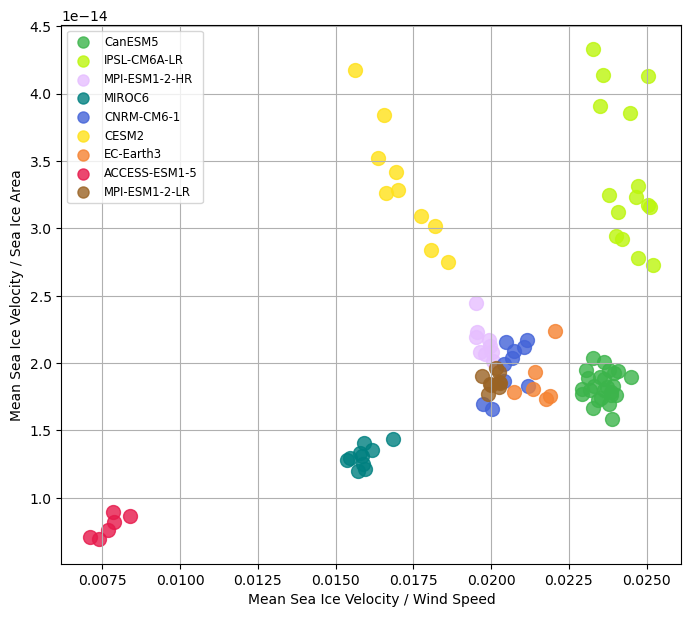

In [25]:
plt.figure(figsize=(8, 7))
plotted_models = set()
for idx, row in results_df.iterrows():
    model = row["Model"]
    x = row["Velocity/Wind"]
    y = row["Velocity/Area"]
    color = model_colors.get(model, "#000000")

    if model not in plotted_models:
        plt.scatter(x, y, color=color, s=100, alpha=0.8, label=model)
        plotted_models.add(model)
    else:
        plt.scatter(x, y, color=color, s=100, alpha=0.8)

plt.xlabel("Mean Sea Ice Velocity / Wind Speed")
plt.ylabel("Mean Sea Ice Velocity / Sea Ice Area")
# plt.title("Comparison of Sea Ice Drift Sensitivity (March) by Ensemble Member")
plt.grid(True)
plt.legend(loc="best", fontsize="small", markerscale=0.8)
plt.savefig("final_drift_sensitivity_scatter_ensembles.png", dpi=300, bbox_inches="tight")
plt.show()